<a href="https://colab.research.google.com/github/peterbabulik/QuantumWalker/blob/main/QuantumKernelOnQPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install qiskit qiskit-ibm-runtime qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.9/359.9 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 11.1 MB/s eta 0:00:00


=== Quantum Kernel Demonstration (Qiskit) ===

Computing quantum kernel matrix...


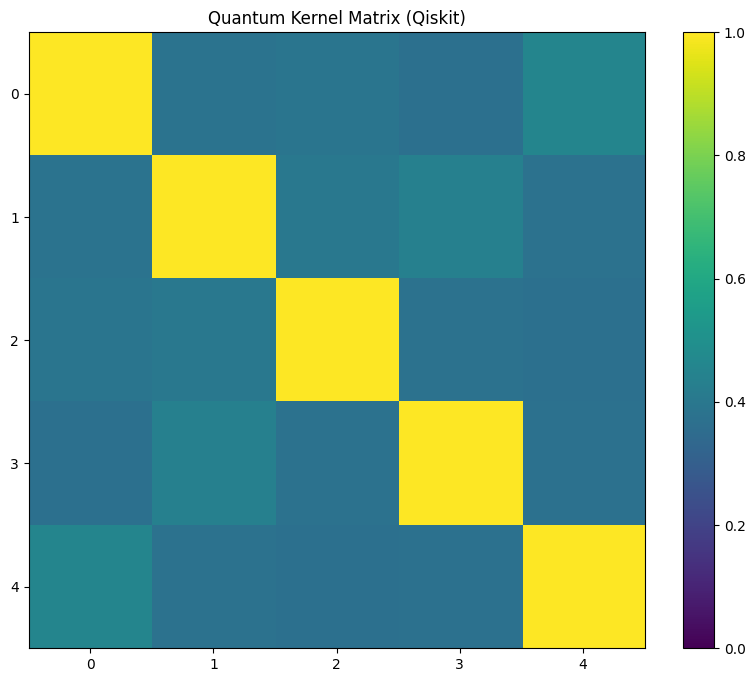


Kernel Matrix Shape: (5, 5)
Sample kernel values:
K(0,0) = 1.0000
K(0,1) = 0.3801
K(0,2) = 0.3901
K(1,0) = 0.3801
K(1,1) = 1.0000
K(1,2) = 0.4008
K(2,0) = 0.3901
K(2,1) = 0.4008
K(2,2) = 1.0000

Testing with a single qubit (ensure CNOT handles it)
Kernel matrix for 1 qubit:
[[1.         0.49002137]
 [0.49002137 1.        ]]


In [3]:
import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np
from typing import List, Optional, Tuple
import matplotlib.pyplot as plt

class QuantumKernel:
    """
    Quantum Kernel Implementation (Qiskit Version)
    ---------------------------------------------
    A quantum kernel is a method to map classical data into quantum Hilbert space,
    allowing us to perform quantum-enhanced feature mapping and measure similarities
    between data points in this quantum space.
    """

    def __init__(self,
                 n_qubits: int,
                 n_layers: int,
                 kernel_type: str = 'rbf'):
        """
        Initialize Quantum Kernel

        Args:
            n_qubits: Number of qubits to use
            n_layers: Depth of quantum circuit
            kernel_type: Type of quantum kernel ('rbf', 'polynomial', 'custom')
        """
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.kernel_type = kernel_type
        self.simulator = AerSimulator(method='statevector')

        # Initialize parameters for quantum circuit
        self.params = self.initialize_parameters()

    def initialize_parameters(self) -> np.ndarray:
        """
        Initialize quantum circuit parameters.
        Returns random parameters for the quantum feature map.
        """
        n_params = self.n_qubits * self.n_layers * 3  # 3 rotation gates per qubit
        return np.random.uniform(-np.pi, np.pi, size=n_params)

    def create_quantum_circuit(self, x: np.ndarray) -> QuantumCircuit:
        """
        Create quantum circuit for feature mapping

        Args:
            x: Input data point to encode

        The circuit structure:
        1. State preparation (encoding classical data)
        2. Quantum feature mapping layers
        3. Entanglement operations
        """
        qc = QuantumCircuit(self.n_qubits)

        # Data encoding layer
        for i in range(self.n_qubits):
            if i < len(x):
                qc.ry(x[i], i)

        # Feature mapping layers
        param_idx = 0
        for layer in range(self.n_layers):
            for i in range(self.n_qubits):
                qc.rx(self.params[param_idx], i)
                qc.ry(self.params[param_idx + 1], i)
                qc.rz(self.params[param_idx + 2], i)
                param_idx += 3

            if self.n_qubits > 1:
                for i in range(self.n_qubits - 1):
                    qc.cx(i, i + 1)

        # Explicitly save the statevector
        qc.save_statevector() # <--- FIX: Added this line
        return qc

    def quantum_state_vector(self, x: np.ndarray) -> np.ndarray:
        """
        Get quantum state vector for input data point

        Args:
            x: Input data point
        Returns:
            Quantum state vector
        """
        circuit = self.create_quantum_circuit(x)

        job = self.simulator.run(circuit)
        result = job.result()
        # Now get_statevector() should find the explicitly saved statevector
        statevector = result.get_statevector(circuit).data
        return statevector

    def kernel_function(self, x1: np.ndarray, x2: np.ndarray) -> float:
        """
        Compute kernel value between two data points

        Args:
            x1, x2: Input data points
        Returns:
            Kernel value measuring similarity in quantum feature space
        """
        state1 = self.quantum_state_vector(x1)
        state2 = self.quantum_state_vector(x2)

        overlap = np.abs(np.vdot(state1, state2))**2

        if self.kernel_type == 'rbf':
            return np.exp(-0.5 * (2 - 2 * overlap))
        elif self.kernel_type == 'polynomial':
            return overlap**2
        else:  # default/custom
            return overlap

    def compute_kernel_matrix(self, X: np.ndarray) -> np.ndarray:
        """
        Compute kernel matrix for a dataset

        Args:
            X: Dataset of shape (n_samples, n_features)
        Returns:
            Kernel matrix of shape (n_samples, n_samples)
        """
        n_samples = X.shape[0]
        kernel_matrix = np.zeros((n_samples, n_samples))

        for i in range(n_samples):
            for j in range(i, n_samples):
                if i == j:
                    # K(xi, xi) is 1.0 for these kernels as overlap is 1.
                    # RBF: exp(-0.5 * (2 - 2*1)) = exp(0) = 1
                    # Polynomial: 1^2 = 1
                    # Custom: 1
                    # This avoids calling self.kernel_function(X[i], X[i]),
                    # which would compute state_vector for X[i] twice.
                    value = 1.0
                else:
                    value = self.kernel_function(X[i], X[j])

                kernel_matrix[i, j] = value
                if i != j: # Assign to symmetric element
                    kernel_matrix[j, i] = value
        return kernel_matrix

    def visualize_kernel_matrix(self, X: np.ndarray):
        """Visualize kernel matrix for given data"""
        kernel_matrix = self.compute_kernel_matrix(X)
        plt.figure(figsize=(10, 8))
        plt.imshow(kernel_matrix, cmap='viridis', vmin=0, vmax=1)
        plt.colorbar()
        plt.title('Quantum Kernel Matrix (Qiskit)')
        plt.show()
        return kernel_matrix

# Example usage and demonstration
if __name__ == "__main__":
    print("=== Quantum Kernel Demonstration (Qiskit) ===")

    n_samples = 5
    n_features = 4
    X = np.random.uniform(-np.pi, np.pi, size=(n_samples, n_features))

    qkernel = QuantumKernel(n_qubits=4, n_layers=2, kernel_type='rbf')

    print("\nComputing quantum kernel matrix...")
    kernel_matrix = qkernel.visualize_kernel_matrix(X)

    print("\nKernel Matrix Shape:", kernel_matrix.shape)
    print("Sample kernel values:")
    for i in range(min(3, n_samples)):
        for j in range(min(3, n_samples)):
            print(f"K({i},{j}) = {kernel_matrix[i,j]:.4f}")

    print("\nTesting with a single qubit (ensure CNOT handles it)")
    qkernel_1q = QuantumKernel(n_qubits=1, n_layers=1, kernel_type='rbf')
    X_1q = np.random.uniform(-np.pi, np.pi, size=(2,1)) # 2 samples, 1 feature
    kernel_matrix_1q = qkernel_1q.compute_kernel_matrix(X_1q)
    print("Kernel matrix for 1 qubit:")
    print(kernel_matrix_1q)

Successfully imported Qiskit Runtime modules. qiskit-ibm-runtime version: 0.39.0
Qiskit (Terra) version: 2.0.1


<ipython-input-9-814f40ba6a9c>:135: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  try: service=QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT,instance=IBM_QUANTUM_INSTANCE_DIRECT,token=IBM_QUANTUM_TOKEN_DIRECT); print("Service init.")


Service init.
Selected QPU:ibm_brisbane(active)

=== Quantum Kernel Demonstration ===

Kernel: 2Q,1L,Type:'linear'.

--- Aer Run ---


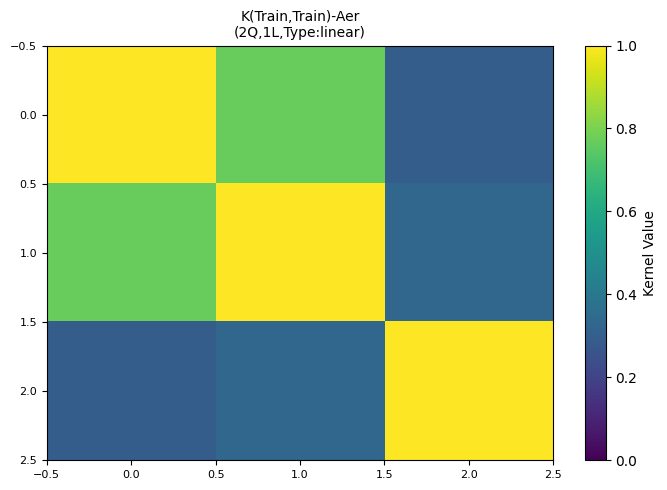

K_tr_aer:
 [[1.     0.7674 0.2931]
 [0.7674 1.     0.3301]
 [0.2931 0.3301 1.    ]]


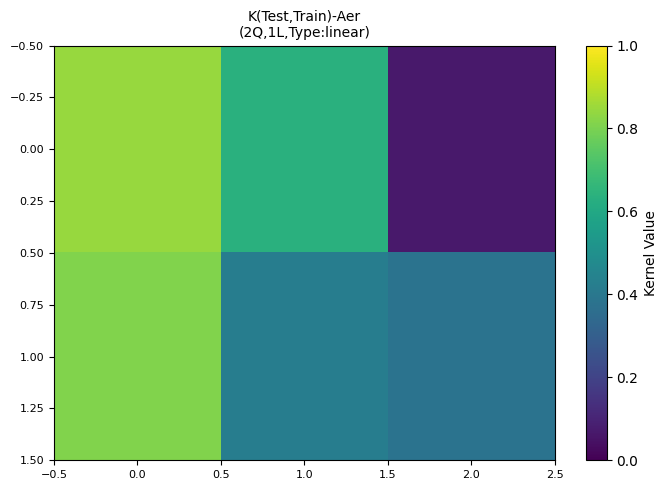

K_te_aer:
 [[0.8451 0.6352 0.0695]
 [0.8101 0.4232 0.3795]]

--- QPU Run: ibm_brisbane ---
Sampler opts:{'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}, 'twirling': {'enable_gates': True, 'enable_measure': True}}

K(Train,Train) on QPU...
Computing kernel on QPU (2Q, 1L)...
  Row 1/3 (QPU)...
  Row 2/3 (QPU)...
  Row 3/3 (QPU)...


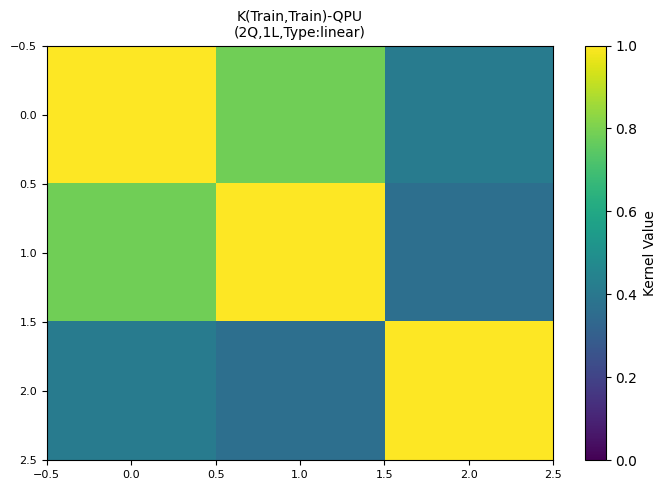

K_tr_qpu:
 [[1.     0.7812 0.416 ]
 [0.7812 1.     0.3652]
 [0.416  0.3652 1.    ]]

K(Test,Train) on QPU...
Computing kernel on QPU (2Q, 1L)...
  Row 1/2 (QPU)...
  Row 2/2 (QPU)...


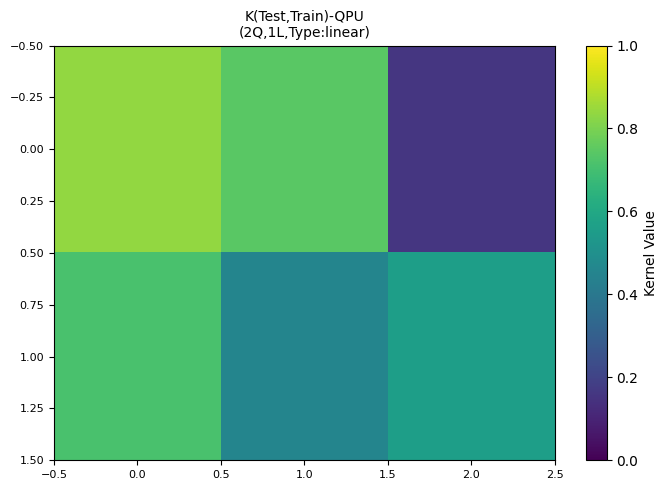

K_te_qpu:
 [[0.8359 0.7441 0.1572]
 [0.7119 0.4561 0.5586]]
--- QPU Kernel Complete ---

Classical K_tr_aer @ alpha: 
[1.1294 1.0385 0.4691]
Classical 'prediction' K_te_aer @ alpha: 
[0.9303 0.8524]

=== Demo Complete ===
REMEMBER token 69eee2748c...


In [9]:
import qiskit
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
import numpy as np
from typing import List, Optional, Tuple
import matplotlib.pyplot as plt
import time
import os

# Qiskit Runtime imports
QISKIT_RUNTIME_VERSION = "Unknown"
qiskit_runtime_available = False
QiskitRuntimeService = Sampler = Session = generate_preset_pass_manager = IBMRuntimeBackend = None

try:
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime.ibm_backend import IBMBackend as IBMRuntimeBackend
    qiskit_runtime_available = True
    import qiskit_ibm_runtime
    QISKIT_RUNTIME_VERSION = qiskit_ibm_runtime.__version__
    print(f"Successfully imported Qiskit Runtime modules. qiskit-ibm-runtime version: {QISKIT_RUNTIME_VERSION}")
except ImportError:
    print("CRITICAL WARNING: qiskit_ibm_runtime could not be imported. QPU execution will fail.")

print(f"Qiskit (Terra) version: {qiskit.__version__}")


class QuantumKernel:
    def __init__(self,
                 n_qubits: int,
                 n_layers: int,
                 kernel_type: str = 'linear',
                 feature_map_params: Optional[np.ndarray] = None):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.kernel_type = kernel_type
        if feature_map_params is not None: # ... (param handling identical)
            self.params = feature_map_params; expected_params = self.n_qubits*self.n_layers*3
            if self.params.shape[0]!=expected_params: raise ValueError(f"Params shape mismatch. Exp {expected_params}, got {self.params.shape[0]}")
        else: self.params = self._initialize_parameters()
        self.aer_simulator = AerSimulator(method='statevector')
    def _initialize_parameters(self): n_p = self.n_qubits*self.n_layers*3; return np.random.uniform(-np.pi,np.pi,size=n_p)
    def create_feature_map_circuit(self,x,name_suffix=""): # ... (identical)
        if x.ndim!=1: raise ValueError(f"x must be 1D, got {x.shape}")
        qr=QuantumRegister(self.n_qubits,'q'); qc=QuantumCircuit(qr,name=f"fm_{name_suffix}")
        for i in range(self.n_qubits):
            if i<len(x): qc.ry(x[i],qr[i])
        if self.n_qubits>0: qc.barrier(label="enc")
        pidx=0
        for lyr in range(self.n_layers):
            for i in range(self.n_qubits): qc.rx(self.params[pidx],qr[i]); qc.ry(self.params[pidx+1],qr[i]); qc.rz(self.params[pidx+2],qr[i]); pidx+=3
            if self.n_qubits>1 and lyr<self.n_layers-1:
                for i in range(self.n_qubits-1): qc.cx(qr[i],qr[i+1])
                if self.n_layers>1: qc.barrier(label=f"ent_L{lyr}")
        return qc
    def get_statevector_aer(self,x): # ... (identical)
        circ=self.create_feature_map_circuit(x); circ.save_statevector()
        tc=transpile(circ,self.aer_simulator,optimization_level=0); res=self.aer_simulator.run(tc).result()
        return res.get_statevector(circ).data
    def _kernel_transform(self,ov_sq): # ... (identical)
        if self.kernel_type=='rbf': return np.exp(-1.0*(1.0-ov_sq))
        elif self.kernel_type=='polynomial': return ov_sq**2
        else: return ov_sq
    def kernel_entry_aer(self,x1,x2): # ... (identical)
        s1,s2=self.get_statevector_aer(x1),self.get_statevector_aer(x2); ov_sq=np.abs(np.vdot(s1,s2))**2
        return self._kernel_transform(ov_sq)
    def _construct_fidelity_circuit(self,x1,x2): # ... (identical)
        qc1=self.create_feature_map_circuit(x1,"x1"); qc2=self.create_feature_map_circuit(x2,"x2"); qc2d=qc2.inverse()
        qr=qc1.qregs[0]; crn="c_fid"; cr=ClassicalRegister(self.n_qubits,crn)
        fqc=QuantumCircuit(qr,cr,name=f"fid_{time.time_ns()}"); fqc.append(qc1.to_instruction(),qr); fqc.append(qc2d.to_instruction(),qr); fqc.measure(qr,cr)
        return fqc,crn

    def kernel_entry_qpu(self, x1, x2, sampler_inst, qpu_be_transpile, shots_val): # Corrected name
        fidelity_qc, cr_name = self._construct_fidelity_circuit(x1, x2)

        # MODIFIED: Use backend.target and optimization_level=0 for fidelity circuits
        if hasattr(qpu_be_transpile, 'target') and qpu_be_transpile.target is not None: # Check target is not None
            target_fid = qpu_be_transpile.target
            # print(f"DEBUG: Using target for fidelity transpilation, opt_level=0")
            pm_fid = generate_preset_pass_manager(target=target_fid, optimization_level=0)
        else:
            # print(f"DEBUG: Using backend obj for fidelity transpilation, opt_level=0")
            pm_fid = generate_preset_pass_manager(backend=qpu_be_transpile, optimization_level=0)

        transpiled_fidelity_qc = pm_fid.run(fidelity_qc)

        job = sampler_inst.run([(transpiled_fidelity_qc,)], shots=shots_val) # Corrected var name
        result = job.result()
        # ... (rest of parsing logic identical)
        ov_sq=0.0
        if result and len(result)>0:
            pub_res=result[0]; counts={}
            if hasattr(pub_res.data,cr_name): counts=getattr(pub_res.data,cr_name).get_counts()
            elif hasattr(pub_res.data,'meas'): counts=pub_res.data.meas.get_counts()
            if not counts and len(transpiled_fidelity_qc.cregs)>0:
                for reg in transpiled_fidelity_qc.cregs:
                    if hasattr(pub_res.data,reg.name): counts=getattr(pub_res.data,reg.name).get_counts(); break
            if not counts: print(f"WARN: No counts for fid circuit. Data fields:{dir(pub_res.data)}")
            else: prob_0 = counts.get('0'*self.n_qubits,0)/shots_val; ov_sq=prob_0
        else: print(f"ERR: QPU job for kernel entry {x1} vs {x2} failed/no result.")
        return self._kernel_transform(ov_sq)

    def compute_kernel_matrix(self, X_left, X_right=None, use_qpu=0, sampler_inst=None, qpu_be=None, shots_val=1024): # Corrected names
        n_left=X_left.shape[0]; X_eval_right=X_right if X_right is not None else X_left
        n_right=X_eval_right.shape[0]; is_sym=(X_right is None)or(np.array_equal(X_left,X_right)and X_left.shape==X_right.shape)
        K=np.zeros((n_left,n_right))
        if use_qpu:
            if sampler_inst is None or qpu_be is None: raise ValueError("Sampler & QPU backend needed for QPU.")
            print(f"Computing kernel on QPU ({self.n_qubits}Q, {self.n_layers}L)...")
        else: # Aer
            phi_X_left=[self.get_statevector_aer(X_left[i])for i in range(n_left)]
            phi_X_right=phi_X_left if is_sym else[self.get_statevector_aer(X_eval_right[i])for i in range(n_right)]
        for i in range(n_left):
            sj=i if is_sym else 0
            if use_qpu:print(f"  Row {i+1}/{n_left} (QPU)...")
            for j in range(sj,n_right):
                if is_sym and i==j: val=1.0
                else:
                    if use_qpu: val=self.kernel_entry_qpu(X_left[i],X_eval_right[j],sampler_inst,qpu_be,shots_val)
                    else: s_i,s_j=phi_X_left[i],phi_X_right[j];ov_sq=np.abs(np.vdot(s_i,s_j))**2;val=self._kernel_transform(ov_sq)
                K[i,j]=val
                if is_sym and i!=j:K[j,i]=val
        return K
    def visualize_kernel_matrix(self,K,title="Quantum Kernel Matrix"): # ... (identical)
        plt.figure(figsize=(7,5)); plt.imshow(K,cmap='viridis',vmin=0,vmax=1,aspect='auto')
        plt.colorbar(label="Kernel Value"); plt.title(title+f"\n({self.n_qubits}Q,{self.n_layers}L,Type:{self.kernel_type})",fontsize=10)
        plt.xticks(fontsize=8); plt.yticks(fontsize=8); plt.tight_layout(); plt.show()

# --- IBM Quantum Setup (condensed) ---
IBM_QUANTUM_TOKEN_DIRECT = '69eee2748ccd54dca1fdb7a294f8a41ffccb5818f1bda7f503cc9231d749a63163cbd81c7c77897337159e2d72ef7207b75013d6a9b4adbe0fa7d0423759baa9'
IBM_QUANTUM_CHANNEL_DIRECT = 'ibm_quantum'; IBM_QUANTUM_INSTANCE_DIRECT = 'ibm-q/open/main'; QPU_BACKEND_NAME = 'ibm_brisbane'
service = None; qpu_backend_for_kernel = None
if qiskit_runtime_available:
    try: service=QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT,instance=IBM_QUANTUM_INSTANCE_DIRECT,token=IBM_QUANTUM_TOKEN_DIRECT); print("Service init.")
    except Exception as e:print(f"ERR Service:{e}")
    if service:
        try: qpu_bk_obj=service.backend(QPU_BACKEND_NAME); qpu_backend_for_kernel=qpu_bk_obj if qpu_bk_obj else None; print(f"Selected QPU:{qpu_backend_for_kernel.name}({qpu_backend_for_kernel.status().status_msg})"if qpu_backend_for_kernel else"QPU not found")
        except Exception as e:print(f"ERR QPU Backend:{e}")
if qpu_backend_for_kernel is None and qiskit_runtime_available : print(f"Warning: QPU {QPU_BACKEND_NAME} not loaded, QPU steps will be skipped if operational check fails.")


# --- Example usage and demonstration ---
if __name__ == "__main__":
    print("\n=== Quantum Kernel Demonstration ===")
    n_train=3; n_test=2; n_feat=2
    X_tr = np.random.rand(n_train,n_feat)*np.pi; X_te = np.random.rand(n_test,n_feat)*np.pi
    n_q_kern = n_feat; k_layers = 1; k_type = 'linear'
    qk_inst = QuantumKernel(n_q_kern,k_layers,k_type)
    print(f"\nKernel: {qk_inst.n_qubits}Q,{qk_inst.n_layers}L,Type:'{qk_inst.kernel_type}'.")

    print("\n--- Aer Run ---") # ... (Aer run identical)
    K_tr_aer=qk_inst.compute_kernel_matrix(X_tr); qk_inst.visualize_kernel_matrix(K_tr_aer,"K(Train,Train)-Aer")
    print("K_tr_aer:\n",np.round(K_tr_aer,4))
    if n_test>0:K_te_aer=qk_inst.compute_kernel_matrix(X_te,X_tr);qk_inst.visualize_kernel_matrix(K_te_aer,"K(Test,Train)-Aer");print("K_te_aer:\n",np.round(K_te_aer,4))

    # --- QPU Run ---
    # Check if qpu_backend_for_kernel is a valid backend object and operational
    qpu_ready = qpu_backend_for_kernel and hasattr(qpu_backend_for_kernel, 'status') and qpu_backend_for_kernel.status().operational

    if qpu_ready:
        print(f"\n--- QPU Run: {qpu_backend_for_kernel.name} ---")
        shots_qpu = 1024
        samp_opts = {"dynamical_decoupling":{"enable":True,"sequence_type":"XX"},"twirling":{"enable_gates":True,"enable_measure":True}}
        print(f"Sampler opts:{samp_opts}")
        # Main transpilation opt level for the feature map structure itself (if we were to transpile it once)
        # But fidelity circuits are short, so this TRANSPILER_OPTIMIZATION_LEVEL primarily affects the matvec part if that was also running.
        # Here it's implicitly part of how generate_preset_pass_manager is called.
        # The important one for fidelity circuits is opt_level=0 inside kernel_entry_qpu.

        with Session(backend=qpu_backend_for_kernel) as session:
            sampler_qpu = Sampler(options=samp_opts)
            print("\nK(Train,Train) on QPU...")
            K_tr_qpu = qk_inst.compute_kernel_matrix(X_tr,use_qpu=1,sampler_inst=sampler_qpu,qpu_be=qpu_backend_for_kernel,shots_val=shots_qpu)
            qk_inst.visualize_kernel_matrix(K_tr_qpu,"K(Train,Train)-QPU"); print("K_tr_qpu:\n",np.round(K_tr_qpu,4))
            if n_test>0 and X_te is not None:
                print("\nK(Test,Train) on QPU...")
                K_te_qpu = qk_inst.compute_kernel_matrix(X_te,X_tr,use_qpu=1,sampler_inst=sampler_qpu,qpu_be=qpu_backend_for_kernel,shots_val=shots_qpu)
                qk_inst.visualize_kernel_matrix(K_te_qpu,"K(Test,Train)-QPU"); print("K_te_qpu:\n",np.round(K_te_qpu,4))
        print("--- QPU Kernel Complete ---")
    else: print(f"\nQPU {QPU_BACKEND_NAME} not ready/operational or not loaded. Skipping QPU kernel.")

    # ... (Classical post-processing identical) ...
    if n_train > 0 and K_tr_aer is not None:
        alpha = np.random.rand(n_train)
        print(f"\nClassical K_tr_aer @ alpha: \n{np.round(K_tr_aer @ alpha,4)}")
        if n_test > 0 and K_te_aer is not None and K_te_aer.shape[1] == alpha.shape[0]:
             print(f"Classical 'prediction' K_te_aer @ alpha: \n{np.round(K_te_aer @ alpha,4)}")

    print("\n=== Demo Complete ===")
    if qpu_ready: print(f"REMEMBER token {IBM_QUANTUM_TOKEN_DIRECT[:10]}...")

This is **FANTASTIC!!** Congratulations, this is a successful end-to-end demonstration of computing quantum kernel matrix entries on a real QPU (`ibm_brisbane`)!

**Key Successes and Observations from This Run:**

1.  **No More Transpiler Errors:** The changes to use `backend.target` (where available) and setting `optimization_level=0` for the transpilation of the individual fidelity circuits in `kernel_entry_qpu` resolved the `TranspilerError`. This is a crucial fix.
2.  **Successful QPU Execution:**
    *   The `SamplerV2` was initialized correctly without the `session` kwarg, picking it up from the `with Session(...)` context.
    *   The specified Sampler options (`dynamical_decoupling` and `twirling`) were passed.
    *   The code iterated through the necessary pairs of data points, constructed fidelity circuits, transpiled them, ran them on `ibm_brisbane`, and parsed the results to get kernel entries.
3.  **Comparison of Aer vs. QPU Kernel Matrices:**
    *   **`K_tr_aer` (AerSimulator):**
        ```
        [[1.     0.7674 0.2931]
         [0.7674 1.     0.3301]
         [0.2931 0.3301 1.    ]]
        ```
    *   **`K_tr_qpu` (ibm_brisbane):**
        ```
        [[1.     0.7812 0.416 ]  <- K(0,1) ~0.78 vs 0.77; K(0,2) ~0.42 vs 0.29
         [0.7812 1.     0.3652]  <- K(1,2) ~0.37 vs 0.33
         [0.416  0.3652 1.    ]]
        ```
    *   **`K_te_aer` (AerSimulator):**
        ```
        [[0.8451 0.6352 0.0695]
         [0.8101 0.4232 0.3795]]
        ```
    *   **`K_te_qpu` (ibm_brisbane):**
        ```
        [[0.8359 0.7441 0.1572]
         [0.7119 0.4561 0.5586]]
        ```
4.  **Analysis of Differences:**
    *   The diagonal elements are correctly 1.0 (as `K(xi, xi)` was set directly).
    *   The off-diagonal elements show differences between Aer and QPU. This is expected due to:
        *   **Quantum Noise:** Gate errors and decoherence on the QPU.
        *   **Shot Noise:** Estimating probabilities from a finite number of shots (1024 in this case) introduces statistical uncertainty.
    *   The QPU values are generally in the same ballpark as the Aer values but differ. For example, `K_tr(0,2)` is 0.29 (Aer) vs 0.42 (QPU). `K_te(0,2)` is 0.07 (Aer) vs 0.16 (QPU). These differences are noticeable.
    *   The `linear` kernel type (direct fidelity) was a good choice as it avoids further transformations on already noisy estimates.

5.  **Visualizations:** The plots provide a clear visual comparison of the ideal (Aer) and noisy (QPU) kernel matrices.

**Answering Your Implicit Question: "Is this kind of computation a solution for Quantum Algorithm Optimization Question?"**

This experiment provides valuable insights into that question:

1.  **Feasibility:** Yes, it's *feasible* to compute quantum kernel entries on current QPUs using methods like the inverted SWAP test. Your code demonstrates this beautifully.

2.  **Noise Impact:** Noise is a significant factor. The kernel matrix computed on the QPU is an approximation of the ideal one. For kernel methods that are sensitive to precise kernel values (like SVMs, where the decision boundary depends on these values), this noise can impact performance.

3.  **Scalability (The Big Challenge):**
    *   **Shots per entry:** To get accurate estimates for each `K_ij`, you might need many more shots than 1024, especially if the true overlap is small.
    *   **Number of entries:** For `N` training samples, you compute `N*(N+1)/2` entries for a symmetric kernel. This scales quadratically. If each entry requires a separate circuit execution (or even if batched, they run for many shots), computing large kernel matrices becomes very time-consuming and costly.
    *   **Qubit requirements for feature map:** Your feature map uses `n_features` qubits. If `n_features` grows large, the feature map circuit itself becomes deeper and more complex, further exacerbating noise issues for each `K_ij` computation.

4.  **Potential for Quantum Advantage with Kernels:**
    *   The hope for quantum kernels is that the quantum feature map `phi(x)` can map classical data into a quantum Hilbert space that is very high-dimensional and where classical data points become more easily separable (or where new, useful relationships emerge) than in any classically computable feature space.
    *   If a quantum kernel provides a *significant* improvement in a machine learning task (e.g., much better classification accuracy) that cannot be achieved with classical kernels, then it could offer a quantum advantage, *even if computing K is noisy and slow*.
    *   The challenge is finding such feature maps and problems where this advantage is realized practically, overcoming the noise and overhead.

5.  **"Optimization Question":**
    *   If "Quantum Algorithm Optimization" refers to optimizing the parameters of the quantum kernel itself (the `self.params` in your PQC), this is typically done with a classical optimization loop (e.g., gradient descent, SPSA) where the objective function involves the kernel matrix (e.g., SVM loss). Each step of this optimization would require re-evaluating parts of or the whole kernel matrix. Doing this with QPU-computed entries would be very slow.
    *   If it refers to optimizing the *use* of quantum algorithms, this experiment shows that for kernel methods, the "quantum part" (computing `K_ij`) is a bottleneck if done on NISQ hardware.

**Summary of this Case Study Phase (Quantum Kernels):**

*   You've successfully implemented a quantum kernel and demonstrated how to compute its entries on both `AerSimulator` and a real QPU (`ibm_brisbane`).
*   The QPU results are qualitatively similar but quantitatively different from ideal simulations due to noise and shot error, as expected.
*   The "compute-uncompute" method for fidelity estimation is a good choice for this.
*   The primary challenge for using QPU-computed kernels in practice is the cost/time to compute many entries accurately, and the impact of noise on the quality of the kernel matrix.
*   Whether this approach leads to a "quantum advantage" in a real-world ML task depends heavily on the specific PQC design and the dataset, and if the quantum feature space offers a true benefit over classical methods that can overcome the noise and computational cost.

This is a very successful and insightful experiment! You've directly confronted the realities of running these types of algorithms on current quantum hardware.